# Download dependencies



In [13]:
%tensorflow_version 1.x

In [14]:
!git clone https://github.com/NVlabs/stylegan2.git

fatal: destination path 'stylegan2' already exists and is not an empty directory.


In [15]:
import sys
sys.path.insert(0, "/content/stylegan2")

In [16]:
import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks
import numpy as np
import PIL.Image
import pickle
import pandas as pd
from IPython.display import display
import shutil
import copy
import glob

In [17]:
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

In [18]:
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 4
noise_vars = [
    var for name, var in Gs.components.synthesis.vars.items()
    if name.startswith('noise')
]
w_avg = Gs.get_var('dlatent_avg')
truncation_psi = 0.75

In [19]:
! wget https://github.com/a312863063/generators-with-stylegan2/raw/master/latent_directions/age.npy    

--2022-03-20 08:11:35--  https://github.com/a312863063/generators-with-stylegan2/raw/master/latent_directions/age.npy
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/a312863063/generators-with-stylegan2/master/latent_directions/age.npy [following]
--2022-03-20 08:11:35--  https://raw.githubusercontent.com/a312863063/generators-with-stylegan2/master/latent_directions/age.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73856 (72K) [application/octet-stream]
Saving to: ‘age.npy.1’

age.npy.1           100%[===================>]  72.12K  --.-KB/s    in 0.005s  

2022-03-20 08:11:35 (14.1 MB/s) -

In [20]:
! wget https://github.com/a312863063/generators-with-stylegan2/raw/master/latent_directions/gender.npy


--2022-03-20 08:11:35--  https://github.com/a312863063/generators-with-stylegan2/raw/master/latent_directions/gender.npy
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/a312863063/generators-with-stylegan2/master/latent_directions/gender.npy [following]
--2022-03-20 08:11:35--  https://raw.githubusercontent.com/a312863063/generators-with-stylegan2/master/latent_directions/gender.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73856 (72K) [application/octet-stream]
Saving to: ‘gender.npy.1’

gender.npy.1        100%[===================>]  72.12K  --.-KB/s    in 0.005s  

2022-03-20 08:11:35 (

In [21]:
! git clone https://github.com/agiardina/stylegan2-directions.git

fatal: destination path 'stylegan2-directions' already exists and is not an empty directory.


# Load directions

We load directions and we set min and max value for each directions. Note: the age and gender directions have been created by https://github.com/a312863063 and are not part of this project.

In [22]:
v = {}
v["age"] = np.load('age.npy')
v["age"] = v["age"]/np.linalg.norm(v["age"])
v["gender"] = np.load('gender.npy')
v["gender"] = v["gender"]/np.linalg.norm(v["gender"])
v["blueeyes"] = np.load("stylegan2-directions/directions/blueeyes.npy")
v["honeyeyes"] = np.load("stylegan2-directions/directions/honeyeyes.npy")
v["eyebrow"] = np.load("stylegan2-directions/directions/eyebrown.npy")
v["nose"] = np.load("stylegan2-directions/directions/nose.npy")
v["lips"] = np.load("stylegan2-directions/directions/lips.npy")
v["chin"] = np.load("stylegan2-directions/directions/chin.npy")



In [23]:
b = {}
b["age"] = [-20,20]
b["gender"] = [-20,20]
b["blueeyes"] = [-20,20]
b["honeyeyes"] = [-30,30]
b["eyebrow"] = [-40,40]
b["nose"] = [-20,20]
b["lips"] = [-20,20]
b["chin"] = [-30,30]

# Test the directions

We test the direction and the range of values with one image to visually check the results



In [24]:
def test_image(image_number):
  w = np.load("stylegan2-directions/latentspaces/{}_latentspace_restyle.npy".format(image_number))
  if w.shape == (18,512):
    w = np.expand_dims(w, axis=0)
  w.shape
  n = 5
  size = 256
  canvas = PIL.Image.new('RGB', (n * size, size))
  for key in v.keys():
    for i, v_magn in enumerate(np.linspace(b[key][0], b[key][1], n)):
        w_age = w + v_magn * v[key]
        image = Gs.components.synthesis.run(w_age, **Gs_syn_kwargs)[0]
        image = PIL.Image.fromarray(image)
        image = image.resize((size, size), PIL.Image.LANCZOS)
        canvas.paste(image, (i * size, 0))
    canvas.save(key+'.png')
    print(key)
    display(PIL.Image.open(key+".png"))

For a list of valid ids check the availables latent codes: https://github.com/agiardina/stylegan2-directions/tree/main/latentspaces



age


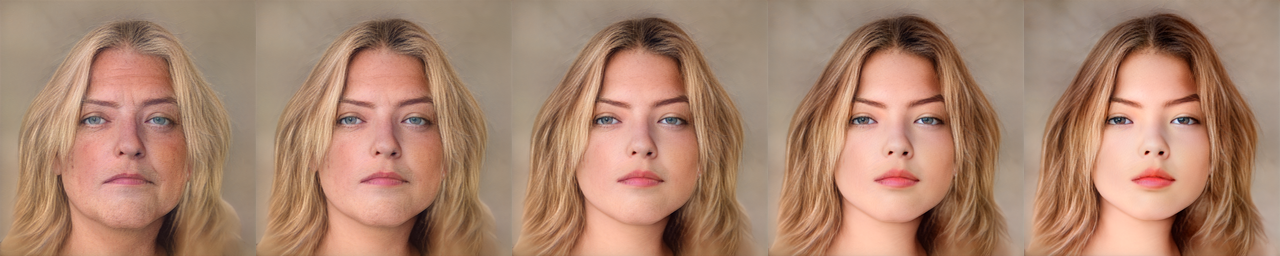

gender


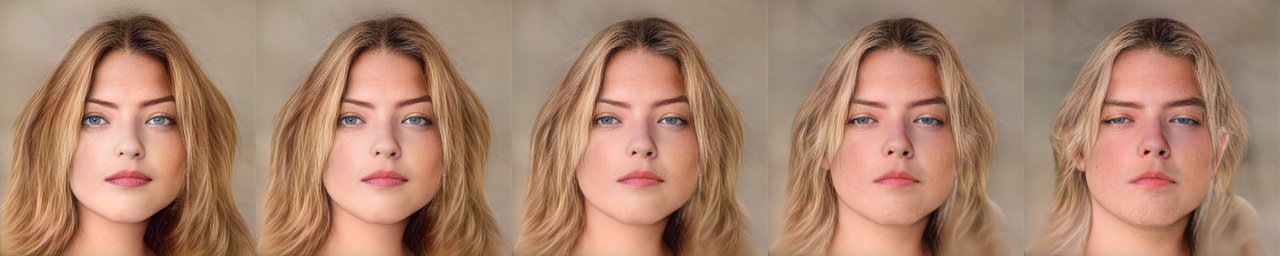

blueeyes


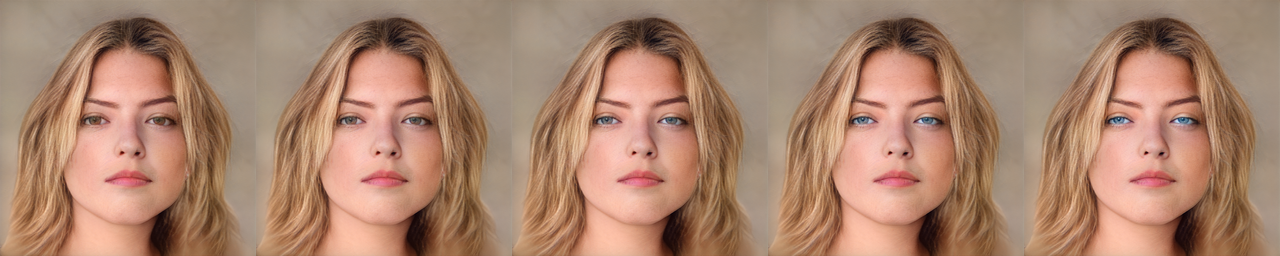

honeyeyes


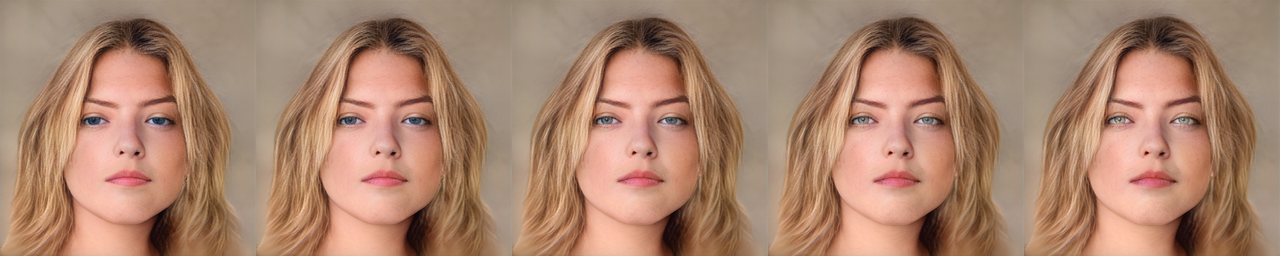

eyebrow


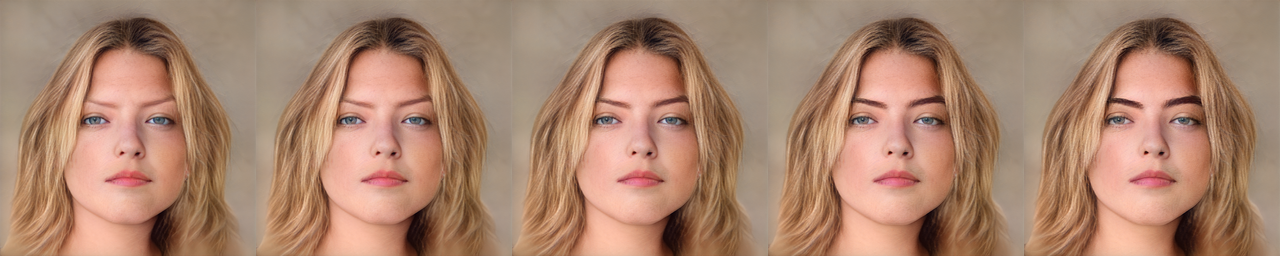

nose


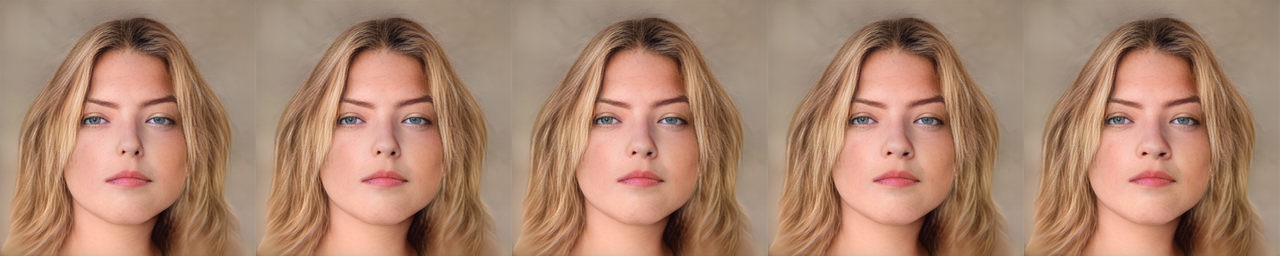

lips


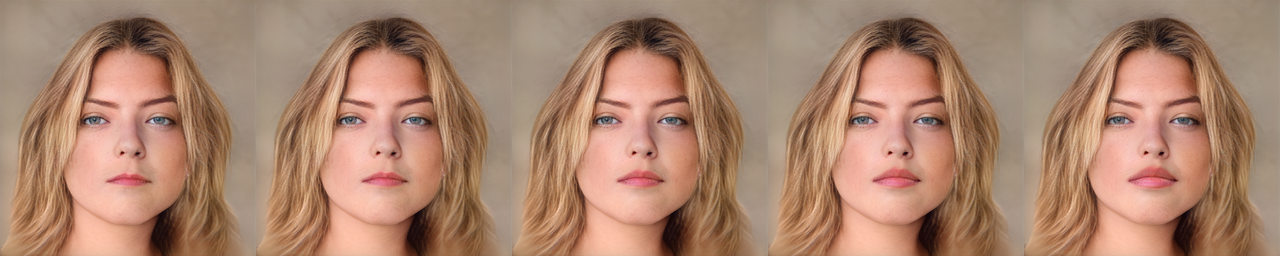

chin


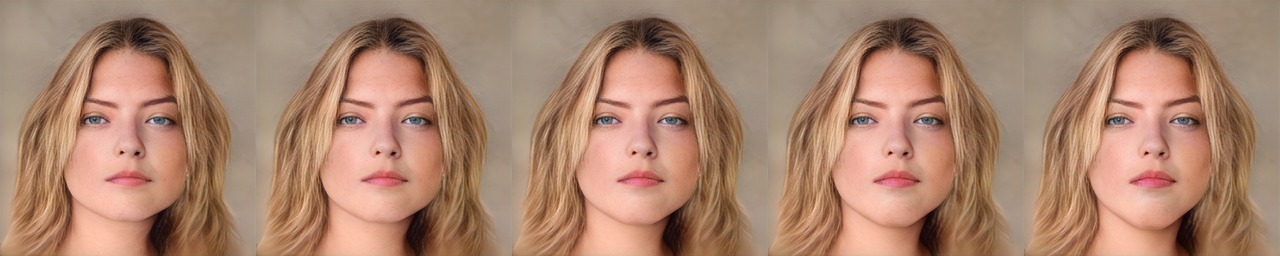

In [25]:
test_image(91)

We generate all variations for all photos. We will generated the photos available here: https://github.com/agiardina/stylegan2-directions/tree/main/output 

# Generate the output folder

In [ ]:
! rm -fr output
! mkdir output

In [ ]:
df = pd.DataFrame(columns=['filename', 'generated','sex','age', 'gender','blueeyes','eyebrow','nose','lips','chin'])

In [ ]:
row_template = {'filename':'', 'generated':1,'sex':'','age':0, 'gender':0,'blueeyes':0,'eyebrow':0,'nose':0,'lips':0,'chin':0}

In [ ]:
df.head()

In [ ]:
def process_image(df,image_number):
  original = "stylegan2-directions/img/{}.jpg".format(image_number)
  target = "output/{}_aligned.jpg".format(image_number)
  shutil.copyfile(original,target)
  row = copy.copy(row_template)
  row["generated"] = 0
  row["filename"] = "{}_aligned.jpg".format(image_number)
  df.head()
  df = df.append(row,ignore_index=True)


  w = np.load("stylegan2-directions/latentspaces/{}_latentspace_restyle.npy".format(image_number))
  if w.shape == (18,512):
    w = np.expand_dims(w, axis=0)

  image = Gs.components.synthesis.run(w, **Gs_syn_kwargs)[0]
  image = PIL.Image.fromarray(image)
  image.save("output/{}_projected.jpg".format(image_number),quality=90)
  row = copy.copy(row_template)
  row["filename"] = "{}_projected.jpg".format(image_number)
  df = df.append(row,ignore_index=True)

  n = 5
  size = 512
  canvas = PIL.Image.new('RGB', (n * size, size))
  for key in v.keys():
    for i, v_magn in enumerate(np.linspace(b[key][0], b[key][1], n)):
      if (v_magn != 0):
        w_mod = w + v_magn * v[key]
        if (v_magn > 0):
          pref = "pos"
        else:
          pref = "neg"

        image = Gs.components.synthesis.run(w_mod, **Gs_syn_kwargs)[0]
        image = PIL.Image.fromarray(image)
        filename = "{}_{}_{}{}.jpg".format(image_number,key,pref,int(abs(v_magn)),quality=90)
        filepath = "output/"+filename
        image.save(filepath)

        row = copy.copy(row_template)
        row["filename"] = filename
        row[key] = int(v_magn)
        df = df.append(row,ignore_index=True)

        print(filename)

  return df

In [ ]:
for file in glob.glob("stylegan2-directions/img/*.jpg"):
  n = file.split("/")[-1].split(".")[0]
  df = process_image(df,n)


In [ ]:
df.head(100)

In [ ]:
! tar czf output.tar.gz output

In [ ]:
df.to_excel("output.xlsx") 